<a href="https://colab.research.google.com/github/AT200210/Data_Science/blob/main/DL/DigitRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

,count
label,
1,4684
7,4401
3,4351
9,4188
2,4177
6,4137
0,4132
4,4072
8,4063


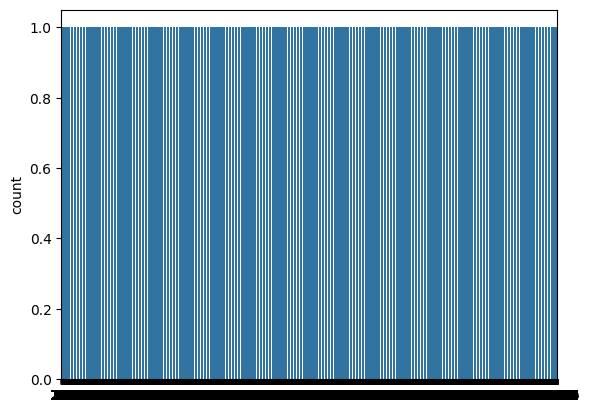

In [3]:

Y_train=train['label']

X_train=train.drop(labels=['label'],axis=1)

del train

g=sns.countplot(Y_train)

Y_train.value_counts()

In [4]:
X_train.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


In [5]:
test.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


In [6]:
X_train=X_train/255.0
test=test=test/255.0

In [7]:
# Reshape the image in 3 dimesions (height=28px, width=28px, channel=1)
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

# keras requires an extra dimension in the end which will correspond to channels.
# for grayscale images we use one channel if we had rgb then we would have used dime. (28,28,3)


In [8]:
Y_train=to_categorical(Y_train,num_classes=10)

In [9]:
X_train, X_val, Y_train, Y_val=train_test_split(X_train,Y_train,test_size=0.2,random_state=42)

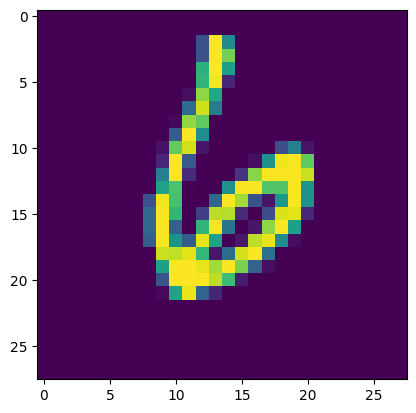

In [10]:
g=plt.imshow(X_train[0][:,:,0])

In [11]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5), padding="Same", activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32,kernel_size=(5,5), padding="Same", activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64,kernel_size=(3,3), padding="Same", activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3), padding="Same", activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))

In [12]:
optimizer=RMSprop(learning_rate=0.001,rho=0.9,epsilon=1e-08,decay=0.0)

In [13]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [16]:
# To prevent overfitting
datagen=ImageDataGenerator(featurewise_center=False, # set input mean to 0 over the dataset
                           samplewise_center=False, # set each sample mean to 0
                           featurewise_std_normalization=False, # divide inputs by std of the dataset
                           samplewise_std_normalization=False, # divide each input by its std
                           zca_whitening=False, # apply ZCA whitening
                           rotation_range=10, # randomly rotate images in the range
                           zoom_range=0.1, # randomly zoom image
                           height_shift_range=0.1, # randomly shift images horizontally
                           width_shift_range=0.1,  # randomly shift images vertically
                           horizontal_flip=False, # randomly flip images
                           vertical_flip=False) # randomly flip images

datagen.fit(X_train)

In [19]:
hostory=model.fit(datagen.flow(X_train,Y_train, batch_size=86), epochs=2, validation_data=(X_val,Y_val), verbose=2, steps_per_epoch=X_train.shape[0] // 86, callbacks=[learning_rate_reduction])

Epoch 1/2
390/390 - 23s - 58ms/step - accuracy: 0.8593 - loss: 0.4405 - val_accuracy: 0.9740 - val_loss: 0.0751 - learning_rate: 1.0000e-03
Epoch 2/2
390/390 - 1s - 2ms/step - accuracy: 0.9419 - loss: 0.1942 - val_accuracy: 0.9807 - val_loss: 0.0604 - learning_rate: 1.0000e-03


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


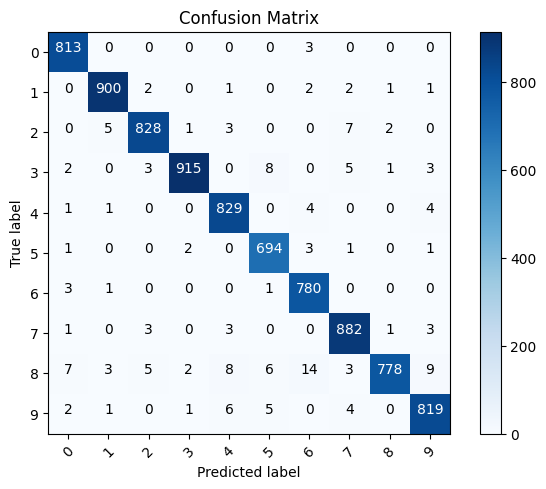

In [25]:
def plot_confusion_matrix(cm, classes, noramlize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if noramlize:
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

  thresh=cm.max()/2

  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,cm[i,j], horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Y_pred=model.predict(X_val)
Y_pred_classes=np.argmax(Y_pred, axis=1)
Y_true=np.argmax(Y_val, axis=1)
confusion_mtx=confusion_matrix(Y_true, Y_pred_classes)


plot_confusion_matrix(confusion_mtx, classes=range(10))

In [26]:
results=model.predict(test)

results=np.argmax(results, axis=1)

results=pd.Series(results, name='Label')

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [27]:
results

,Label
0,2
1,0
2,9
3,0
4,3
...,...
27995,9
27996,7
27997,3
27998,9
